# Analysis of Data Science Jobs HR Agency Data

## Task description

Anylyse data and draw conclusions based on the received results. Ammend your reasoning with visualization. Using statistical analysis prove whether the conclusions are statistically significant.

In the course of your analysis you must:
1. Identify, which factors influence upon the salary of a "Data Scientist".
2. Answer the key questions of the HR agency:
* Is there a yearly salary growth for the "Data Scientist" jobs?
* Is there a relation between the salaries of the "Data Scientist" and "Data Engineer" jobs in 2022?
* What is the relation between the "Data Scientist" salary and the company size?
* Is there an interrelation between the company size and the presence of the "Data Scientist" or "Data Engineer" jobs in it?
If you find other interesting patterns in the data, also mention them in your analysis.

Demonstrate usage of different statistical tests to check the statistical significance of your conclusions.
* Tests for a numeric feature:
    * One-sample group tests
    * Two-sample groups tests
    * Multiple sample groups tests
* Tests for a categorical feature.

## Dataset

For the analysis we use use the [Data Science Job Salaries](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries) dataset from Kaggle.

Data contains the following columns:
* work_year: year in which the salary has been paid
* experience_level: experience level on this role. The following values are possible:
    * EN — Entry-level/Junior
    * MI — Mid-level/Intermediate
    * SE — Senior-level/Expert
    * EX — Executive-level/Director
* employment_type: employment type for this role. The following values are possible:
    * PT — part time
    * FT — full time
    * CT — contract
    * FL — freelancer
* job_title: title of the role
* salary: brutto salary
* salary_currency: currency in which the salary has been paid (ISO 4217)
* salary_in_usd: salary value converted to USD using the yearly average exchange rate from fxdata.foorilla.com
* employee_residence: main residence country of the employee during the given year (ISO 3166)
* remote_ratio: ration of work which has been done remotely. The following values are possible:
    * 0 — no remove work (< 20 %)
    * 50 — partially remote work (>= 20 % and <= 80 %)
    * 100 — mainly remote work (> 80 %)
* company_location: country of the main employer office (ISO 3166)
* company_size:	average amount of people who worked in the company during the given year. The following values are possible:
    * S — < 50 employees (small company)
    * M — >= 50 and <= 250 employees (middle-size company)
    * L — > 250 employees (large company)

## Import of libraries

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
import sys

sys.path.append('../')

from DataScienceHelpers.DataCleaningAttributes import find_low_information_attributes
from plotly.subplots import make_subplots


## Loading data

In [3]:
data = pd.read_csv('../data/ds_salaries.csv')
display(f'Number of records: {data.shape[0]}')
data.head()

'Number of records: 607'

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Data cleaning

### Empty cells
Identify empty cells and if necessary delete columns / rows which contain them.

In [4]:
data.isnull().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

The dataset does not contain empty cells.

### Low information features

Check if the dataset contains any low information features and delete those. For that I use the DataScienceHelpers library which I have developed in the course of the previous modules.

In [5]:
low_inf_attrs = find_low_information_attributes(data)
low_inf_attrs


[('Unnamed: 0', 1.0, 'nunique_ratio'),
 ('employment_type', 0.9686985172981878, 'top_freq')]

The 'Unnamed: 0' is an external index column, which contains 100 % unique values. This column can be safely dropped, because pandas generates a new index for us while reading data.

The 'employment_type' column contains a value, which is present in around 97 % of the rows. Let's check the frequency of the values of the 'employment_type' column.

In [6]:
data['employment_type'].value_counts()

employment_type
FT    588
PT     10
CT      5
FL      4
Name: count, dtype: int64

The value 'FT' (full time job) is the most frequent one.

Since this feature is not mentioned in the task description, I will drop it in addition to 'Unnamed: 0'.

In [7]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('employment_type', axis=1, inplace=True)

### Duplicates

Check if the dataset contains any duplicates and delete those.

In [8]:
dupl_mask = data.duplicated()
dupl_data = data[dupl_mask]

number_with_duplicates = data.shape[0]
number_of_duplicates = dupl_data.shape[0]

data = data.drop_duplicates()
number_without_duplicates = data.shape[0]

display(f'Number or records with duplicates: {number_with_duplicates}')
display(f'Number of duplicates: {number_of_duplicates}')
display(f'Number or records without duplicates: {number_without_duplicates}')

'Number or records with duplicates: 607'

'Number of duplicates: 42'

'Number or records without duplicates: 565'

### Data type check

For each column check if the column data is matching the data type used within the dataframe.

In [9]:
display(data.head())
data.info()

,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,Machine Learning Engineer,150000,USD,150000,US,50,US,L


<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   job_title           565 non-null    object
 3   salary              565 non-null    int64 
 4   salary_currency     565 non-null    object
 5   salary_in_usd       565 non-null    int64 
 6   employee_residence  565 non-null    object
 7   remote_ratio        565 non-null    int64 
 8   company_location    565 non-null    object
 9   company_size        565 non-null    object
dtypes: int64(4), object(6)
memory usage: 48.6+ KB


Column meaningful data types are matching the data types used in the dataframe.

### Classify feature by type (numeric or categorical)

* work_year - numeric
* experience_level - categorical
* job_title - N/A
* salary - numeric
* salary_currency - categorical
* salary_in_usd - numeric
* employee_residence - categorical
* remote_ratio - categorical
* company_location - categorical
* company_size - categorical

### Main statistical characteristics of the features

In [10]:
display('Statistic characteristics of the features:')
data.describe(include='all')

'Statistic characteristics of the features:'

,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,5.650000e+02,565,565.000000,565,565.000000,565,565
unique,NaN,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,SE,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,243,130,NaN,359,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,3.381160e+05,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,1.599879e+06,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,6.700000e+04,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,1.109250e+05,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.000000,NaN,NaN


Data seems to synthetic, since salary_in_usd median, 3-rd quartile and max value are round: respectively 100000, 150000 and 600000.

## Exploratory data analysis

### Visual data analysis

Basic viaualization of all features available in the dataframe. Numeric features are visualized using Q-Q plots and histograms, categorical and text features are visualized using bar charts.

#### Visualization of numeric features

'Visualizing numeric features:'

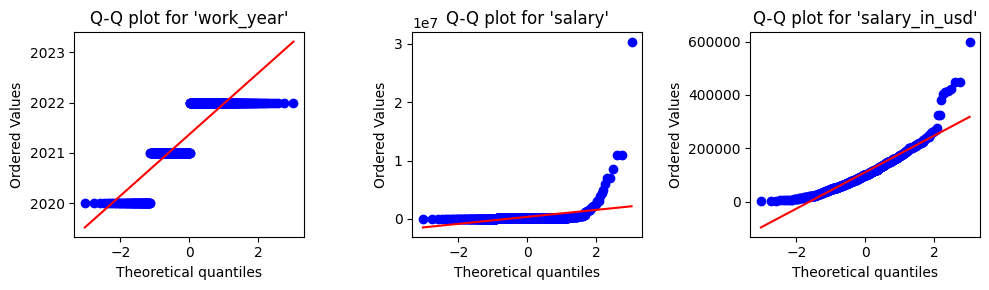

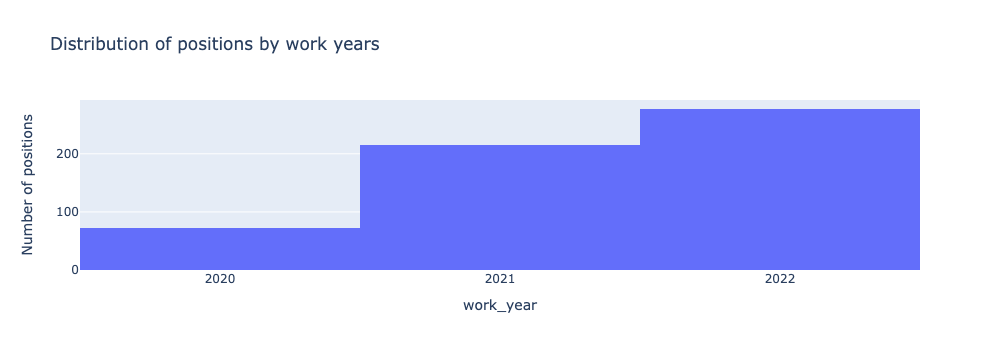

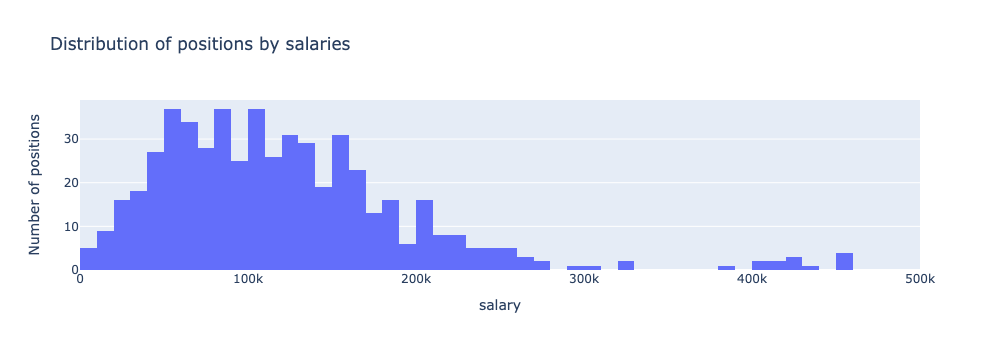

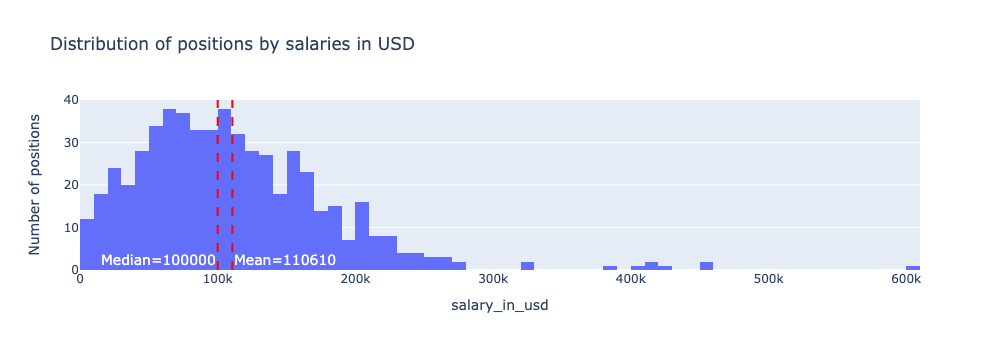

In [56]:
display('Visualizing numeric features:')

# Q-Q plots
plt.subplots(1, 3, figsize=(10, 3))

ax = plt.subplot(1, 3, 1)
stats.probplot(data['work_year'], plot=plt)
ax.set_title('Q-Q plot for \'work_year\'')

ax = plt.subplot(1, 3, 2)
stats.probplot(data['salary'], plot=plt)
ax.set_title('Q-Q plot for \'salary\'')

ax = plt.subplot(1, 3, 3)
stats.probplot(data['salary_in_usd'], plot=plt)
ax.set_title('Q-Q plot for \'salary_in_usd\'')

plt.tight_layout()
plt.show()

# Histograms
fig = px.histogram(
    data_frame=data,
    x='work_year',
    width=1000,
    height=350,
    title='Distribution of positions by work years'
).update_layout(
    yaxis_title='Number of positions',
    xaxis_tickvals=[*range(int(data['work_year'].min()), int(data['work_year'].max())+1)]
)
fig.show('png')

fig = px.histogram(
    data_frame=data,
    x='salary',
    width=1000,
    height=350,
    nbins=5000,
    title='Distribution of positions by salaries'
).update_layout(
    yaxis_title='Number of positions',
    xaxis_range=[0, 500000]
)
fig.show('png')

mean_salary_in_usd = data['salary_in_usd'].mean()
median_salary_in_usd = data['salary_in_usd'].median()
fig = px.histogram(
    data_frame=data,
    x='salary_in_usd',
    width=1000,
    height=350,
    nbins=100,
    title='Distribution of positions by salaries in USD'
).update_layout(
    yaxis_title='Number of positions'
)
fig.add_vline(
    mean_salary_in_usd, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Mean={round(mean_salary_in_usd)}', 
    annotation_position='bottom right',
    annotation_font=dict(size=14, color='white')
)
fig.add_vline(
    median_salary_in_usd, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Median={round(median_salary_in_usd)}', 
    annotation_position='bottom left',
    annotation_font=dict(size=14, color='white')
)
fig.show('png')

#### Conclusion on visualization of numeric features
None of the features has normal distribution.

Work year can be treated as a categorical feature, since there are just three values and each of the positions belongs to one work year.

The salary in the local currency cannot be compared directly across the borders. This feature is not meaningful for further analysis.

Mean and median salary are close to 100000 USD per year.

#### Visualization of the categorical and text features

'Visualizing categorical and text features:'

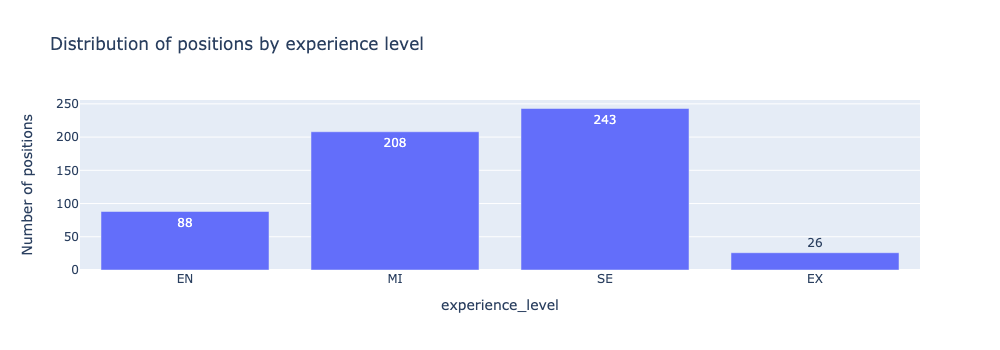

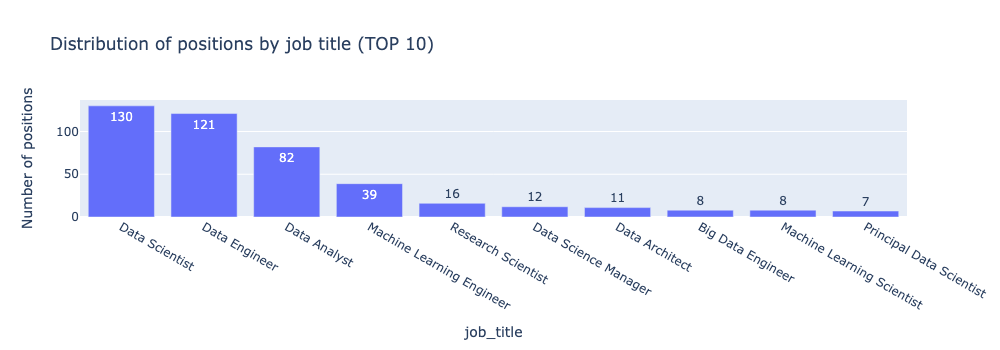

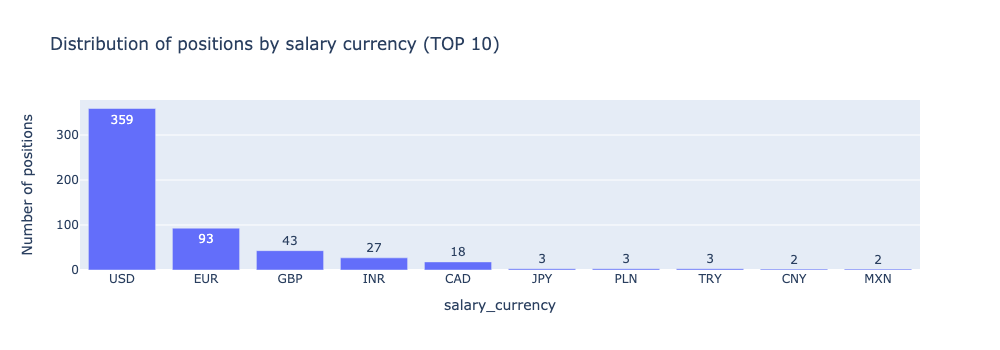

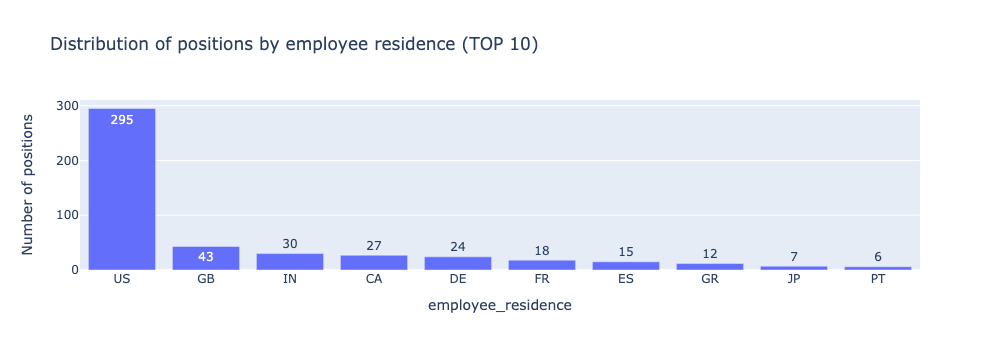

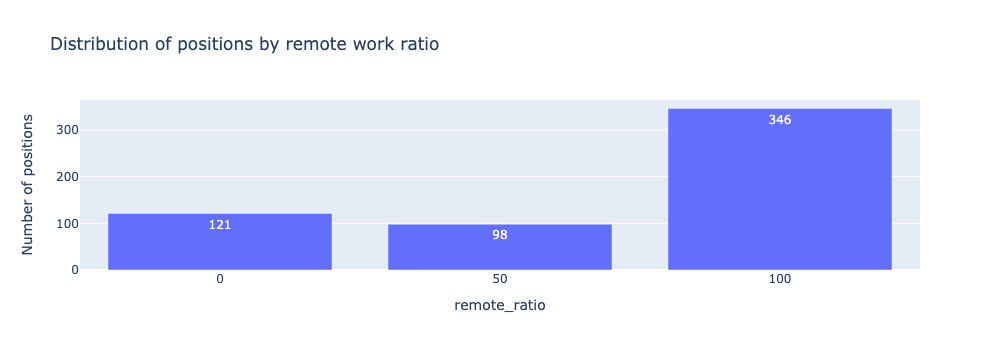

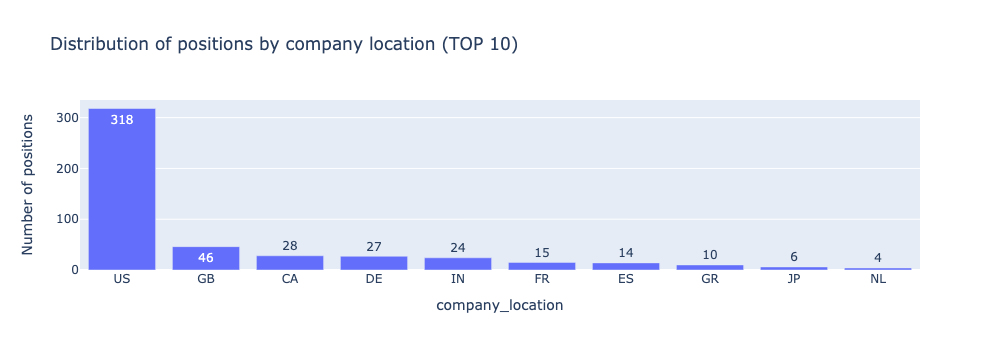

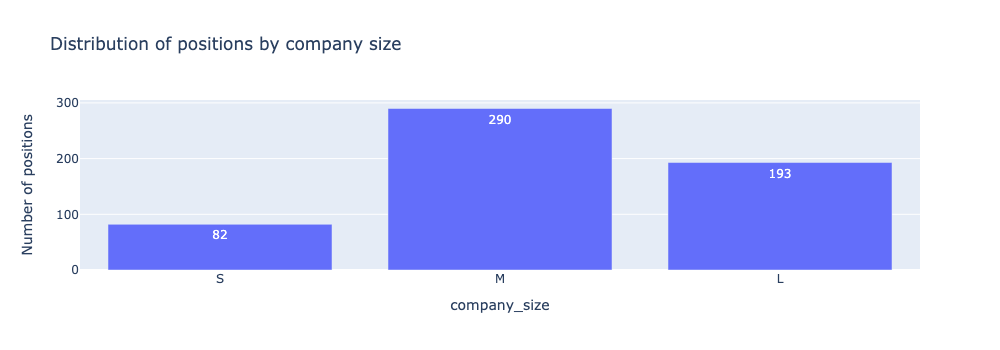

In [71]:
display('Visualizing categorical and text features:')

fig = px.bar(
    data['experience_level'].value_counts(),
    width=1000,
    height=350,
    title='Distribution of positions by experience level',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False,
    xaxis_categoryorder='array',
    xaxis_categoryarray=['EN', 'MI', 'SE', 'EX']
)
fig.show('png')

fig = px.bar(
    data_frame=data['job_title'].value_counts().head(10),
    width=1000,
    height=350,
    title='Distribution of positions by job title (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')

fig = px.bar(
    data_frame=data['salary_currency'].value_counts().head(10),
    width=1000,
    height=350,
    title='Distribution of positions by salary currency (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')

fig = px.bar(
    data_frame=data['employee_residence'].value_counts().head(10),
    width=1000,
    height=350,
    title='Distribution of positions by employee residence (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')

fig = px.bar(
    data_frame=data['remote_ratio'].value_counts(),
    width=1000,
    height=350,
    title='Distribution of positions by remote work ratio',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False,
    xaxis_tickvals=[0, 50, 100]
)
fig.show('png')

fig = px.bar(
    data_frame=data['company_location'].value_counts().head(10),
    width=1000,
    height=350,
    title='Distribution of positions by company location (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')

fig = px.bar(
    data_frame=data['company_size'].value_counts(),
    width=1000,
    height=350,
    title='Distribution of positions by company size',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False,
    xaxis_categoryorder='array',
    xaxis_categoryarray=['S', 'M', 'L']
)
fig.show('png')

#### Conclusion on visualization of the categorical and text features
Most of the jobs are in the middle and senior experience level.

"Data Scientist" and "Data Engineer" are the two most frequent job titles in the data set.

Most of the jobs are paid in USD or EUR.

Most of the companies and most of the employees are located in the following countries: USA, Great Britain, Canada, Germany and India.

More than 50 % of jobs assume remote work.

Middle size companies offer more jobs than small and large companies taken together.

#### Visualize relation between the salary in USD and other features
We consider the salary in USD for the analysis, since the salary in the local currency cannot be compared directly across the borders.

Only job titles "Data Scientist" and "Data Engineer" will be considered for the visualizations in this section.

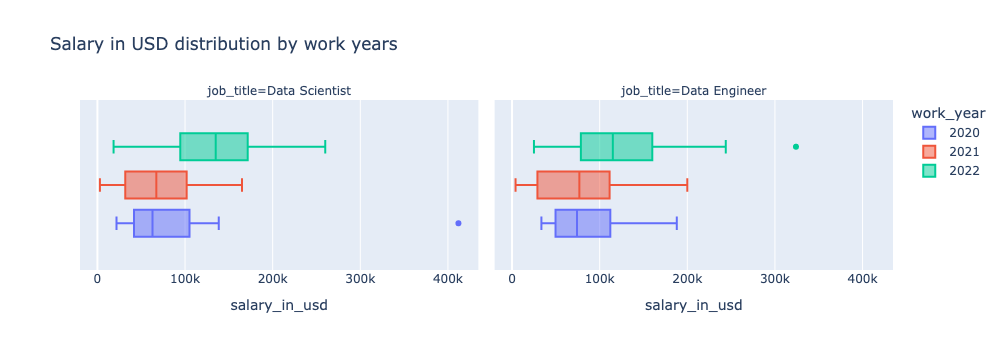

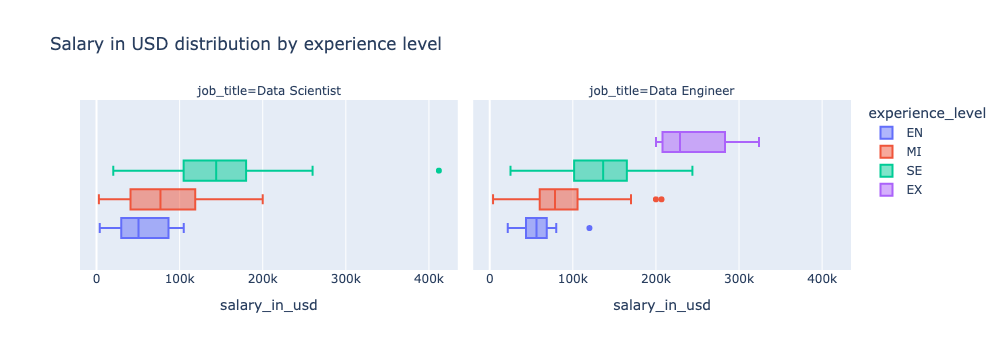

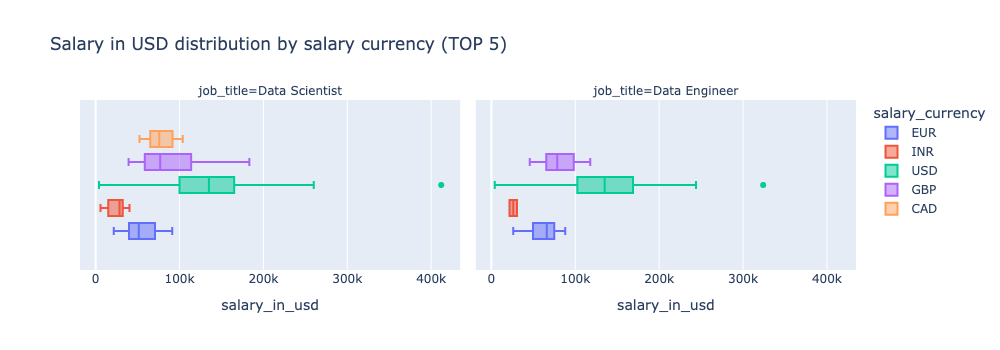

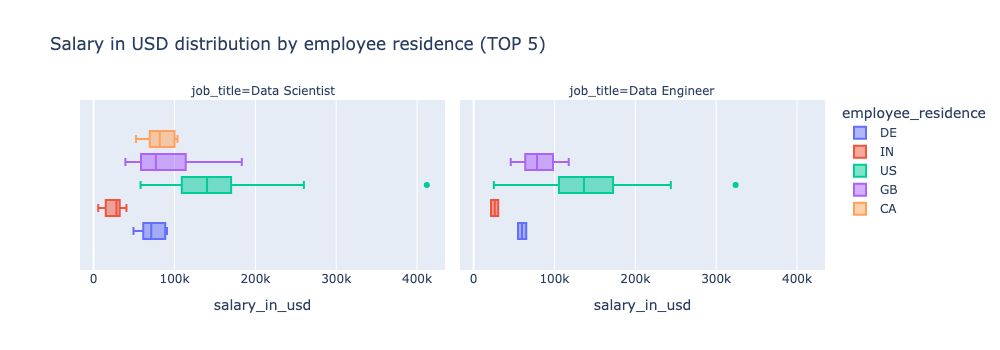

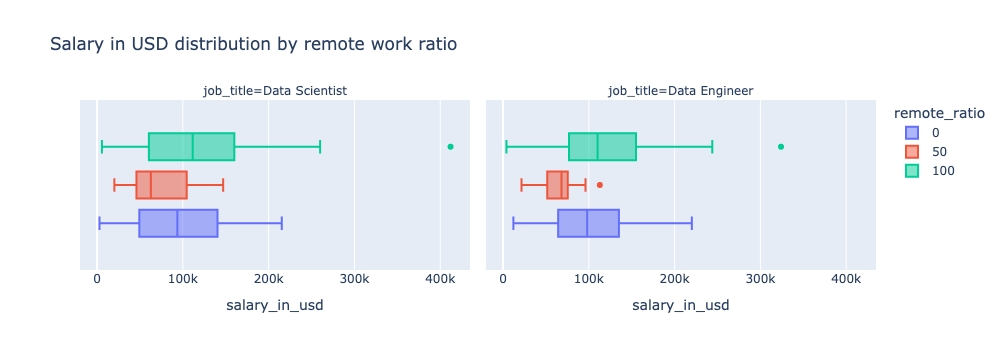

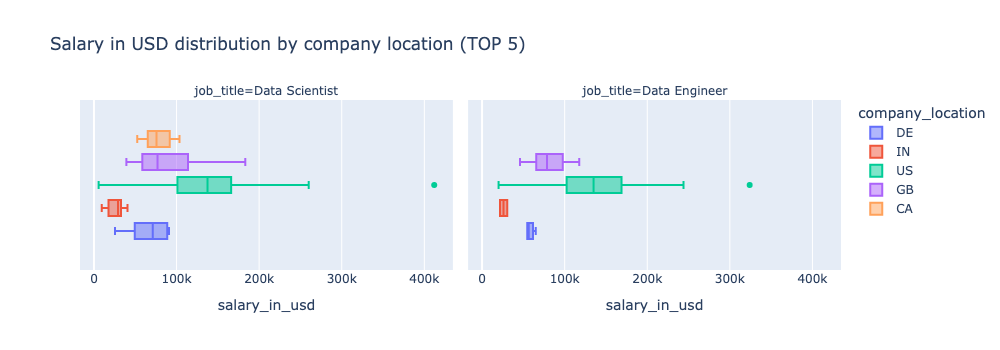

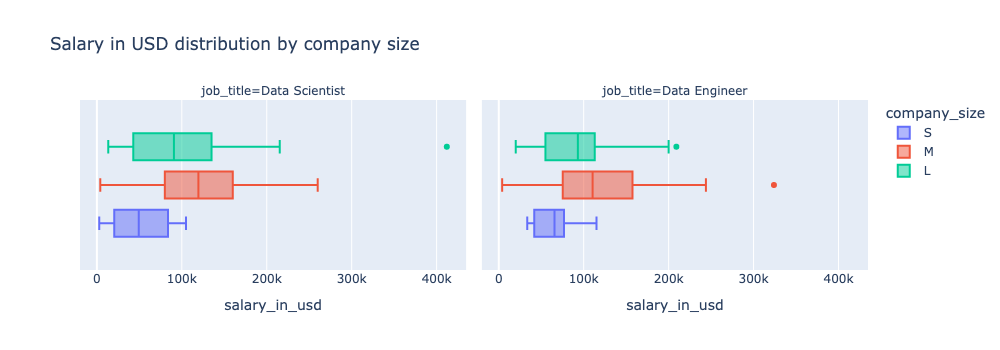

In [133]:
data_jobs_mask = (data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')
data_jobs_data = data[data_jobs_mask]

fig = px.box(
    data_frame=data_jobs_data,
    x='salary_in_usd',
    color='work_year',
    facet_col='job_title',
    width=1000,
    height=350,
    title='Salary in USD distribution by work years'
)
fig.show('png')

fig = px.box(
    data_frame=data_jobs_data,
    x='salary_in_usd',
    color='experience_level',
    facet_col='job_title',
    width=1000,
    height=350,
    title='Salary in USD distribution by experience level',
    category_orders={'experience_level': ['EN', 'MI', 'SE', 'EX']}
)
fig.show('png')

# Diagram is made for the TOP 5 salary currencies
salary_currencies = ['USD', 'EUR', 'GBP', 'INR', 'CAD']
fig = px.box(
    data_frame=data_jobs_data[data_jobs_data['salary_currency'].isin(salary_currencies)],
    x='salary_in_usd',
    color='salary_currency',
    facet_col='job_title',
    width=1000,
    height=350,
    title='Salary in USD distribution by salary currency (TOP 5)'
)
fig.show('png')

# Diagram is made for the TOP 5 employee residences
employee_residence = ['US', 'GB', 'IN', 'CA', 'DE']
fig = px.box(
    data_frame=data_jobs_data[data_jobs_data['employee_residence'].isin(employee_residence)],
    x='salary_in_usd',
    color='employee_residence',
    facet_col='job_title',
    width=1000,
    height=350,
    title='Salary in USD distribution by employee residence (TOP 5)'
)
fig.show('png')

fig = px.box(
    data_frame=data_jobs_data,
    x='salary_in_usd',
    color='remote_ratio',
    facet_col='job_title',
    width=1000,
    height=350,
    title='Salary in USD distribution by remote work ratio'
)
fig.show('png')

# Diagram is made for the TOP 5 company locations
company_location = ['US', 'GB', 'CA', 'DE', 'IN']
fig = px.box(
    data_frame=data_jobs_data[data_jobs_data['company_location'].isin(company_location)],
    x='salary_in_usd',
    color='company_location',
    facet_col='job_title',
    width=1000,
    height=350,
    title='Salary in USD distribution by company location (TOP 5)'
)
fig.show('png')

fig = px.box(
    data_frame=data_jobs_data,
    x='salary_in_usd',
    color='company_size',
    facet_col='job_title',
    width=1000,
    height=350,
    title='Salary in USD distribution by company size',
    category_orders={'company_size': ['S', 'M', 'L']}
)
fig.show('png')


#### Conclusion of visualizing relation between the salary in USD and other features
We'll colclude this part by answering the main questions of our study using the visualizations above.

1. Identify, which factors influence upon the salary of a "Data Scientist". 
    * **_Answer:_** These are: experience level, the currency in which the salary is getting paid, employee residence, remote work ratio, company location and company size (as an additional analysis I'll check if there is a dependency of the salary currency and the employee residence and company location).
2. Answer the key questions of the HR agency:
* Is there a yearly salary growth for the "Data Scientist" jobs? 
    * **_Answer:_** There was a slight decrease from the year 2020 to 2021 and an over 50 % increse from the year 2021 to 2022. I can relate this booming increase with the attention to AI topics as part of the Data Science.
* Is there a relation between the salaries of the "Data Scientist" and "Data Engineer" jobs in 2022? 
    * **_Answer:_** Based on the box plot we can see that the salaries of data engineers are slightly lower than the salaries of data scientists. This applies to all parameters like min and max values and all three quartiles (25 %, 50 % and 75 %).
* What is the relation between the "Data Scientist" salary and the company size? 
    * **_Answer:_** There is not linear grows of the salary along with the company growth. Middle size companies pay more than small companies, but large companies pay less than the middle size companies, but more than the small companies.
* Is there an interrelation between the company size and the presence of the "Data Scientist" or "Data Engineer" jobs in it? 
    * **_Answer:_** Based on the box plots we see that both data scientists and data engineers are present in all sizes of the company.

### Checking statistical hypothesis

#### Normality test
Normality test must be performed for the only numerci feature considered for analysis which is 'salary_in_usd'. We'll use the Shapiro-Wilk test for that.

In [ ]:
# TODO: Shapiro-Wilk test for normality

1. Additional: correlation between salary and country of residence and company country.
2. Distribution of company size and country.
3. Salary dependency from remote work ration.